### Importing necessary libraries (torch, matplotlib)

In [75]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as opt
import torch.nn as nn
import os
import cv2
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Path to training and testing datasets

In [76]:
PATH = "C:/Users/Ato/Documents/Programming/Python/catdog/src/datasets"
train_path = PATH + "/train"
dogs_path = train_path + "/dogs"
cats_path = train_path + "/cats"
test_path = PATH + "/test1"

## Preprocessing and Observations

#### Entries and number of samples of each class

In [77]:
print(len(os.listdir(dogs_path)))
print(len(os.listdir(cats_path)))
print(type(os.listdir(dogs_path)))
print(os.listdir(dogs_path)[20])
print(os.listdir(cats_path)[20])




12500
12500
<class 'list'>
dog.10014.jpg
cat.10014.jpg


- Taking a look at the filenames, it is possible extracting the name and label with ease with:

In [78]:
filenames = os.listdir(dogs_path) + os.listdir(cats_path)
labels = [filename.split('.')[0] for filename in filenames]

In [79]:
raw_data = {'filename': filenames, 'label': labels}
df = pd.DataFrame(raw_data)


In [80]:
df.head()

,filename,label
0,dog.0.jpg,dog
1,dog.1.jpg,dog
2,dog.10.jpg,dog
3,dog.100.jpg,dog
4,dog.1000.jpg,dog


In [81]:
df.describe()

,filename,label
count,25000,25000
unique,25000,2
top,dog.0.jpg,dog
freq,1,12500


#### Checking balance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

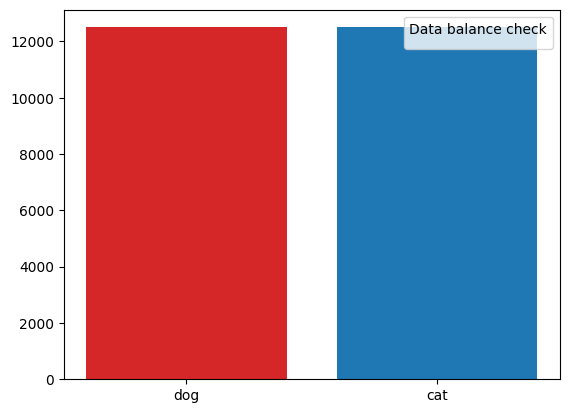

In [82]:
fig, ax = plt.subplots()
bar_labels = df['label'].value_counts().index
counts = df['label'].value_counts().values
bar_colors = ['tab:red', 'tab:blue']

ax.bar(bar_labels, counts, color=bar_colors)
ax.legend(title="Data balance check")

plt.show

The data is balanced! Let's continue.

## Analizing dimensions, shapes, sizes,...

- Take a smaller sample but big enough to contain useful information. sample = 5000

In [83]:
import cv2
from PIL import Image

In [84]:
sample_size = 5000
sample_images = df['filename'].sample(sample_size).to_list()


In [11]:
width = []
height = []
channels = [] # channels

for filename in sample_images:
  if filename in os.listdir(dogs_path):
    image = cv2.imread(os.path.join(dogs_path, filename), 1)

  elif filename in os.listdir(cats_path):
    image = cv2.imread(os.path.join(cats_path, filename), 1)
  else:
    print("File not found in sample set")

  width.append(image.shape[1])
  height.append(image.shape[0])
  channels.append(image.shape[2])




In [17]:
sample_dimensions = pd.DataFrame({
  'width':width,
  'height':height,  
  'channels':channels
})

sample_dimensions.head()

,width,height,channels
0,500,374,3
1,500,415,3
2,400,399,3
3,276,324,3
4,228,399,3


In [18]:
sample_dimensions['aspect ratio'] = sample_dimensions['width']/sample_dimensions['height']

In [15]:
sample_dimensions.head()

,width,height,channels,aspect ratio
0,500,374,3,1.336898
1,500,415,3,1.204819
2,400,399,3,1.002506
3,276,324,3,0.851852
4,228,399,3,0.571429


In [57]:
sample_dimensions.describe()

,width,height,channels,aspect ratio
count,5000.000000,5000.000000,5000.0,5000.000000
mean,406.438400,360.854800,3.0,1.165097
std,107.932557,96.773252,0.0,0.300504
min,54.000000,33.000000,3.0,0.350000
25%,328.000000,301.000000,3.0,0.940000
50%,448.000000,374.000000,3.0,1.287729
75%,499.000000,419.000000,3.0,1.336898
max,1050.000000,768.000000,3.0,5.909091


We calculate the percentile 95th, so we know what value the majority of the features have.

It seems that most of the values are below 500 in width and height and hte aspect ratio is about 1.5, which means that the width is usually 1.5 times bigger than the height.

In [68]:
np.quantile(width, 0.95), np.quantile(height, 0.95), np.quantile(sample_dimensions['aspect ratio'], 0.95)

(500.0, 500.0, 1.5158811151301765)

- Trying with different methods to obtain the quantile. All produce the same value.

In [69]:
np.quantile(width, 0.95, method='hazen'), np.quantile(width, 0.95, method='closest_observation'), np.quantile(width, 0.95, method='higher'), np.quantile(width, 0.95, method='averaged_inverted_cdf'), np.quantile(width, 0.95, method='linear'), np.quantile(width, 0.95, method='median_unbiased')


(500.0, 500, 500, 500.0, 500.0, 500.0)

In [70]:
samplesandnames = sample_dimensions
#print(sample_images[:10])
samplesandnames['filename'] = sample_images

## Removing Outliers

The maximum goal is to preserve quality. From the quantiles, it has been deducted that most of the width and height values fall below 500 while the aspect ratio (AR) is 1.5 in the majority of cases. More data is lost when oversampling the images than when undersampling them, so only the smallest widths and heghts will be removed. Since most of the aspect ratio values fall below 1.5, all AR values between 0.7 and 2 will be removed as well.

- Width > 100
- Height > 150
- 0.7 > Aspect Ratio > 2

These values can be tuned to obtain different results.
**The smaller the range, the lesser data.**


In [71]:
processed_samples = samplesandnames[
  (samplesandnames['width'] >= 100) &
  (samplesandnames['height'] >= 150) &
  (samplesandnames['aspect ratio'] >= 0.7) &
  (samplesandnames['aspect ratio'] <= 2)
]

processed_samples = processed_samples.reset_index(drop=True)


In [72]:
processed_samples.head()

,width,height,channels,aspect ratio,filename
0,500,374,3,1.336898,dog.9745.jpg
1,500,415,3,1.204819,dog.1948.jpg
2,400,399,3,1.002506,dog.11922.jpg
3,276,324,3,0.851852,dog.11861.jpg
4,500,284,3,1.760563,cat.5045.jpg


Now that the **outliers** have been deleted, the amount of data reduced needs to be checked out. Looking at the outcome, most of the images are not considered outliers, although almost 10% of the sample data has been removed.

In [74]:
processed_samples.describe()

,width,height,channels,aspect ratio
count,4532.000000,4532.000000,4532.0,4532.000000
mean,422.654678,363.447043,3.0,1.190345
std,95.433942,86.003206,0.0,0.247497
min,116.000000,150.000000,3.0,0.700000
25%,354.000000,312.000000,3.0,0.995000
50%,480.000000,374.000000,3.0,1.327778
75%,499.000000,405.000000,3.0,1.336898
max,1050.000000,768.000000,3.0,1.996000


# Global Preprocessing

- The same sample preprocessing is now applied to all data.

In [88]:
import cv2
from PIL import Image

In [91]:
df.head(), len(df.filename)

(       filename label
 0     dog.0.jpg   dog
 1     dog.1.jpg   dog
 2    dog.10.jpg   dog
 3   dog.100.jpg   dog
 4  dog.1000.jpg   dog,
 25000)

In [94]:
width = []
height = []

for filename in df['filename']:
  if filename in os.listdir(dogs_path):
    image = cv2.imread(os.path.join(dogs_path, filename))  
  elif filename in os.listdir(cats_path):
    image = cv2.imread(os.path.join(cats_path, filename))
  else:
    raise FileNotFoundError("Filename not found in training set directories!")

  width.append(image.shape[1])
  height.append(image.shape[0])

    

### Outliers Note

- Width > 100
- Height > 150
- 0.7 > Aspect Ratio > 2

In [98]:
full_data = pd.DataFrame({'filename': df['filename'], 'width': width, 'height': height, 'label': df['label']})

In [99]:
full_data['aspect ratio'] = full_data['width'] / full_data['height']

In [102]:
full_data = full_data[
  (full_data['width'] >= 100) &
  (full_data['height'] >= 150) &
  (full_data['aspect ratio'] >= 0.7) &
  (full_data['aspect ratio'] <= 2)
]

- Checking if the data is still balanced after preprocessing. It is!

Text(0, 0.5, 'Count')

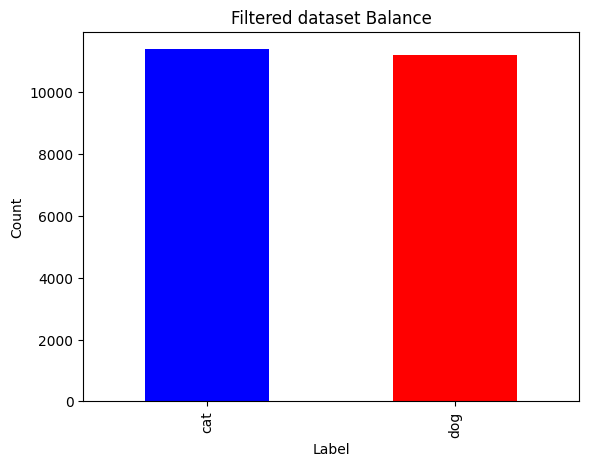

In [106]:
full_data['label'].value_counts().sort_index().plot(kind='bar', color=['blue', 'red'])

plt.title('Filtered dataset Balance')
plt.xlabel('Label')
plt.ylabel('Count')